In [2]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim


nlp = spacy.load('en')

from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

from imp import reload


# Loading the processed DataFrame into notebook
final_df = pd.read_pickle("/Users/Justin/Desktop/ADA_project/final_dataset/quotes_no_firearmo_no_unkown_speakers_with_sent_scores.pkl", compression='infer')

# Remove hour from date timestamp: 
final_df['date'] = final_df.date.dt.date

### The aim of this notebook is to pick a group of quotes and identify subtopics within the general "gun violence" topic. 
Are people talking about specific subjects within gun violence on certain given days? 
What topics seems to come up most often when people talk about gun violence? 
School shootings, senseless violence, regulation, mass shootings, wars abroad? ... 

##### Preparing the model: 

In [3]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [4]:
def make_and_group_chunks(Quotes_to_analyse, chunks):
        
    limit = 60 # how many chunks total
    size = 50 # how many quotes per chunk


    Quotes_to_analyse = training_quotes['quotation'].tolist()

    print('Number of quotes:',len(Quotes_to_analyse))

    # create chunks
    chunks_of_quotes = [x for x in get_chunks(Quotes_to_analyse,size)] # this is a list of lists of sentences, which are a list of tokens

    # regroup so to have a list of chunks which are strings
    for c in chunks_of_quotes:
        grouped_chunk = []
        for s in c:
            grouped_chunk.extend(s)
        chunks.append("".join(grouped_chunk))
    
    return chunks

In [5]:
def filtering_stop_words(chunks, docs):

    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = []
    for doc in nlp.pipe(chunks, n_threads=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 3 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs
    
    # Add bigrams too
    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
            
    return docs

In [6]:
def filter_rare_and_common(dictionary):
    
    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 1
    min_wordcount = 4
    
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    
    return dictionary

In [7]:
def run_LDA(df, num):

    # Date we're analysing: 
    print('Training model with quotes from ' +  str(df['date'].iloc[0]) + ' to ' + str(df['date'].iloc[-1]))


    Quotes_to_analyse = df['quotation'].tolist()

    # Splitting the quotes up into chunks (which group 50 quotes together)
    chunks = []
    chunks = make_and_group_chunks(Quotes_to_analyse, chunks)

    # Eliminating stopwords
    docs = []
    docs = filtering_stop_words(chunks, docs)

    # Create a dictionary representation of the documents and filter out words that occur too frequently or too rarely:
    dictionary = filter_rare_and_common(Dictionary(docs))

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    print('Number of chunks: %d' % len(corpus))
    print('Number of unique tokens: %d' % len(dictionary))

    # Topic detection model: 
    params = {'passes': 10, 'random_state': seed}
    base_models = dict()
    model = LdaMulticore(corpus=corpus, num_topics = num, id2word=dictionary, workers=6,
                         passes=params['passes'], random_state=params['random_state'])
    
    return model, corpus, dictionary

##### Step 3: Run topic detection using LDA

In [8]:
# Building a new dataframe containing the number of quotes per unique day: 
quotes_by_day = final_df.groupby('date').count()['quotation'].to_frame(name = 'num_quotes').reset_index()

# Finding the day with the most quotes within dataset, and saving those quotes to a new df:
training_quotes = final_df[final_df.date == quotes_by_day.iloc[quotes_by_day.num_quotes.idxmax()].date]

# Trying over a time period with lots of quotes, but no significant gun events (look for unobserved constraints):
unexplained_day = final_df[final_df.date == pd.to_datetime('2015-10-02')]
# When we analyse with this day, we end up noticing that there was likely a school shooting within that time frame
# as the keyword shows up more often.
# Indeed, after further research, we notice there was a school shooting in a community college the day before. 


# Turns out there were 1074 quotes about gun violence on the 02/22/2018, we will use these as a training set 
# to try to identify subtopics within these quotes. 

In [25]:
# Call up the functions on the dataframe to analyse - must have "date" and "quotation" column ... 
num_topics = 2
[model, corpus, dictionary] = run_LDA(final_df, num_topics)
import warnings
warnings.filterwarnings("ignore")

Training model with quotes from 2015-07-23 to 2019-09-18
Number of quotes: 616
Number of chunks: 13
Number of unique tokens: 426


In [26]:
# model.show_topics(num_words=5)

In [27]:
# Extracting key words only: 
num_topics = 2
num_key_words = 10

key_words = []
weight = []
group = []
for i in range(num_topics):
    our_list = np.array(model.show_topic(i,num_key_words)).T.tolist()
    key_words = key_words + our_list[0]
    weight = weight + list(np.float_(our_list[1]))
    group = group + (i*np.ones(num_key_words, dtype=int)).tolist()
    
key_topics = pd.DataFrame({'key_words':key_words, 'weight':weight, 'group':group})

# Normalize the weights: 
normed_weight = []
for i in range(num_topics):
    current_topic = key_topics[key_topics.group == i]
    normed_weight = normed_weight + list((current_topic.weight - current_topic.weight.min())/(current_topic.weight.max() - current_topic.weight.min()))
key_topics.weight = normed_weight

In [28]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

[(1, 0.9990863)]

In [29]:
# plot topics
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [32]:
# Save the final plot as HTML file to later add to datastory:
pyLDAvis.save_html(data, '/Users/Justin/Desktop/ADA_project/LDAvis.html')
warnings.filterwarnings("ignore")

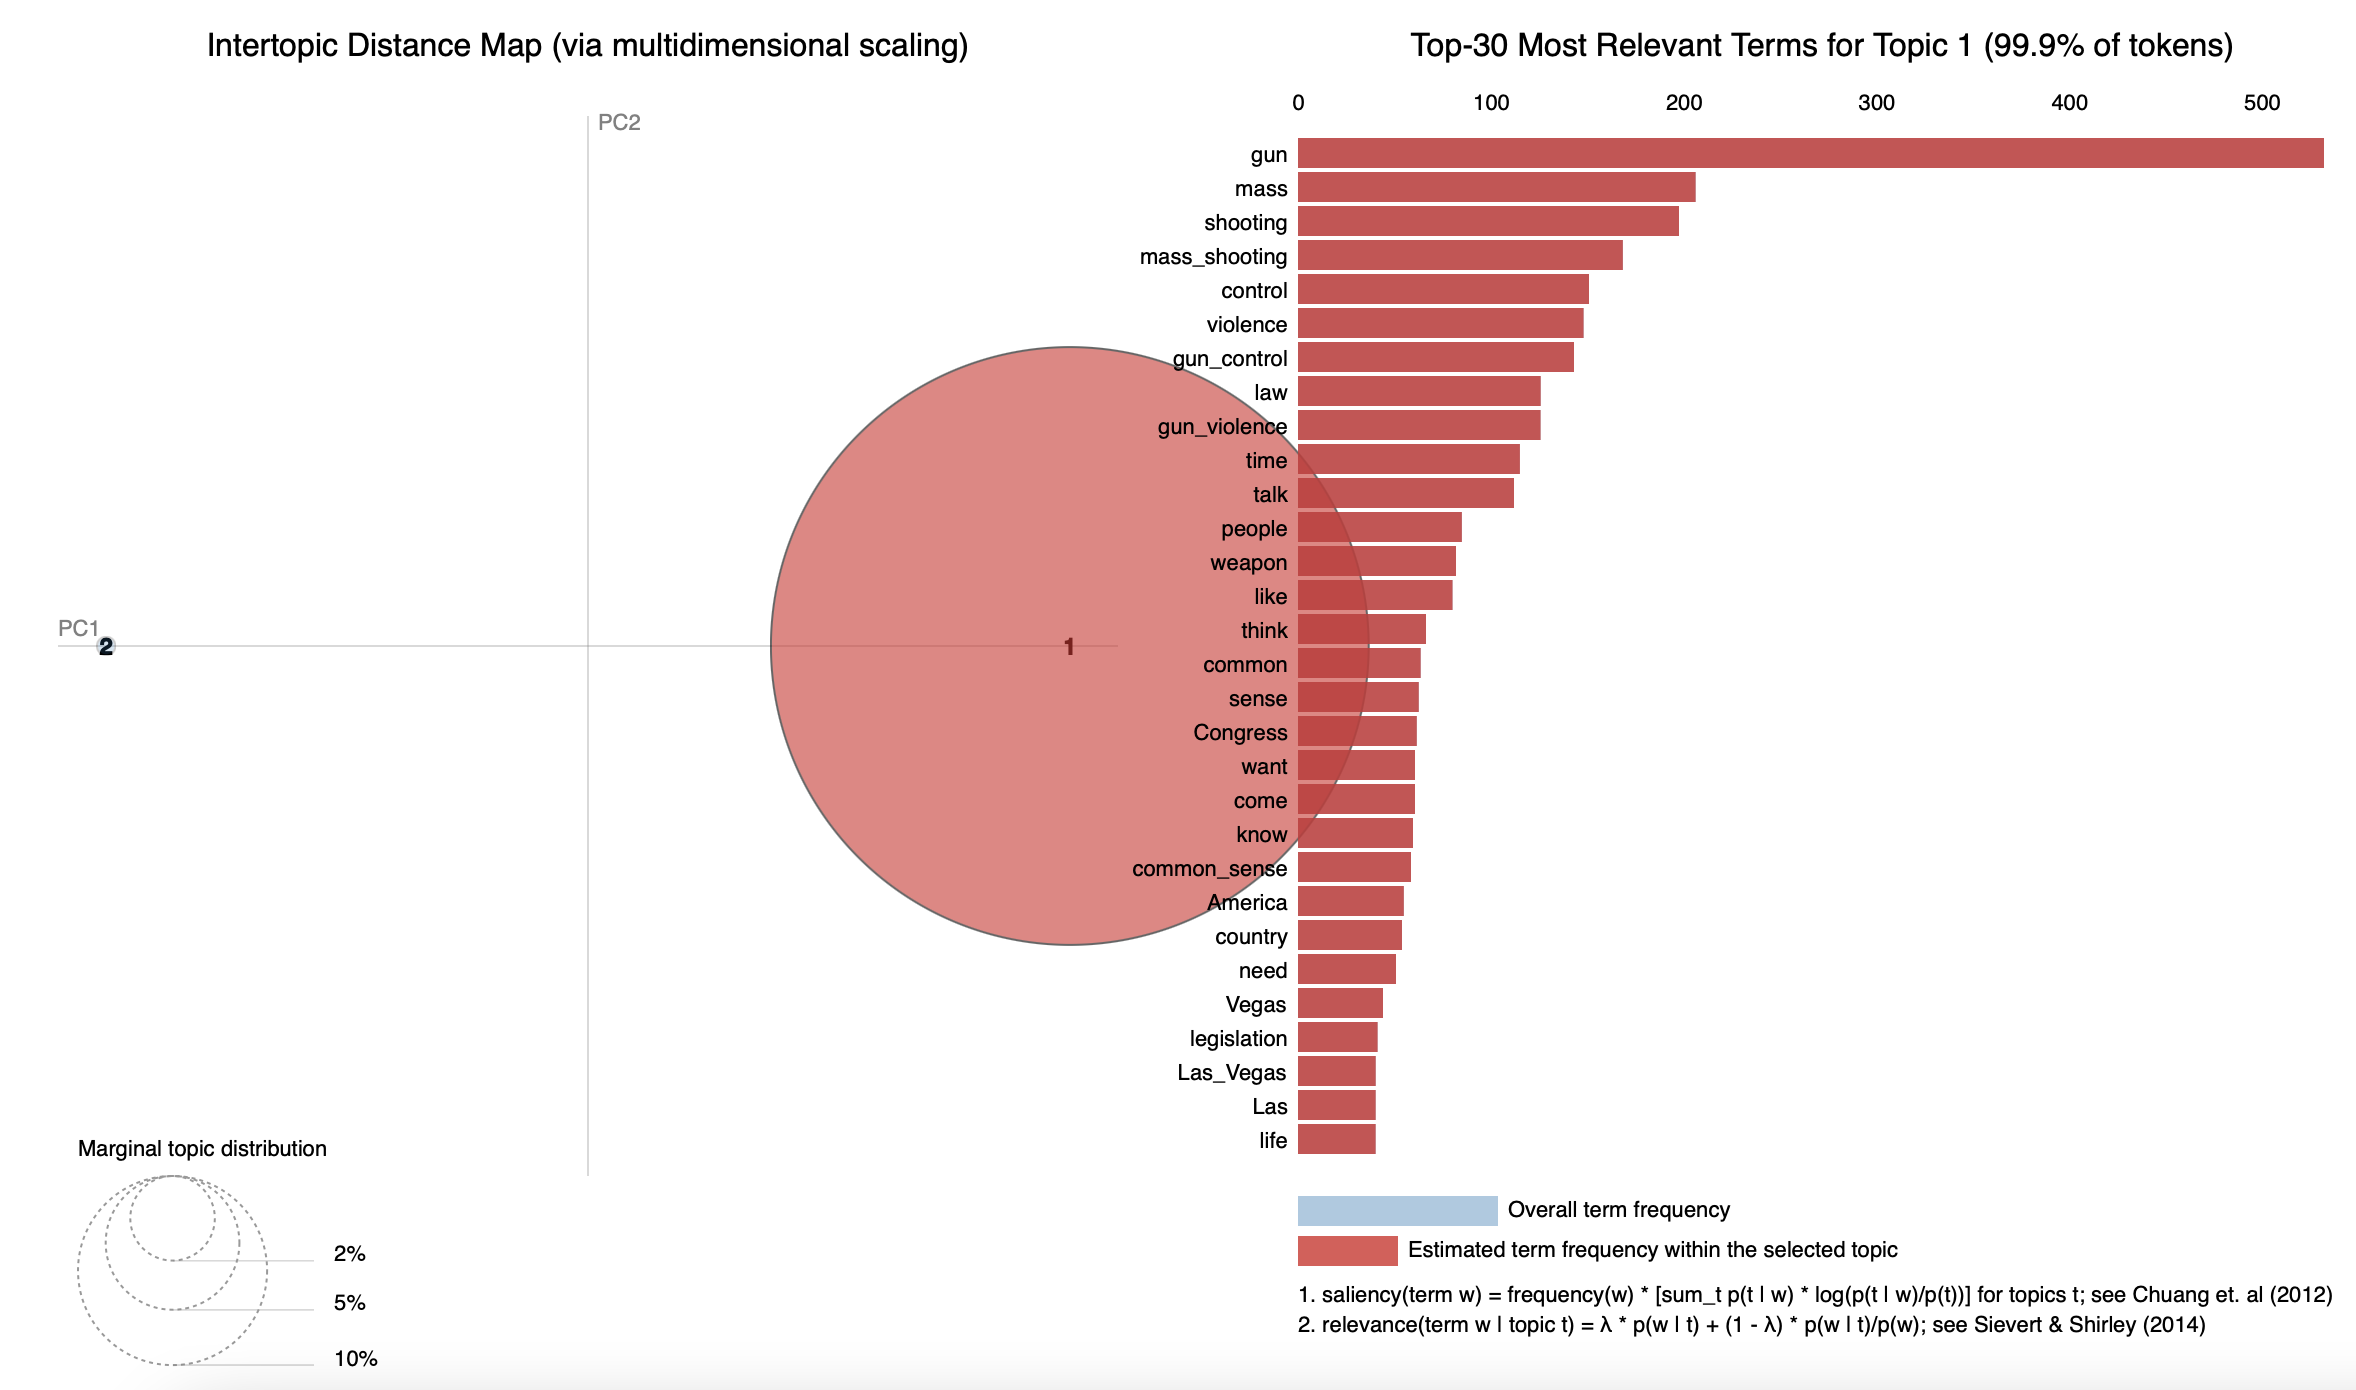

In [34]:
# Displaying the final image for graders: 
from IPython.display import Image
Image("/Users/Justin/Desktop/ADA_project/LDA_results/LDA_result.png")